Imputer RMSE: 1.761

DecisionTreeClassifier (best params={'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 2})
  Train time: 7.43s | Predict time: 0.010s | Accuracy: 0.846
              precision    recall  f1-score   support

    Beginner       0.56      0.64      0.60        92
      Expert       0.89      0.96      0.92       102
Intermediate       0.92      0.86      0.89       390

    accuracy                           0.85       584
   macro avg       0.79      0.82      0.80       584
weighted avg       0.85      0.85      0.85       584



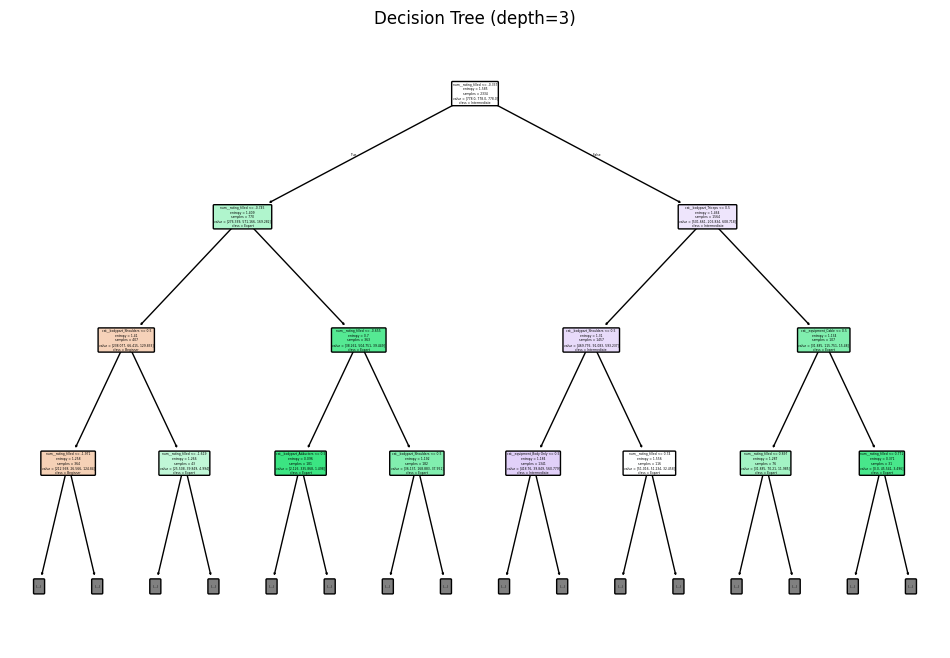


LogisticRegression (best params={'clf__C': 1, 'clf__solver': 'saga'})
  Train time: 2.01s | Predict time: 0.029s | Accuracy: 0.729
              precision    recall  f1-score   support

    Beginner       0.40      0.66      0.50        92
      Expert       0.68      0.96      0.79       102
Intermediate       0.93      0.68      0.79       390

    accuracy                           0.73       584
   macro avg       0.67      0.77      0.69       584
weighted avg       0.80      0.73      0.74       584



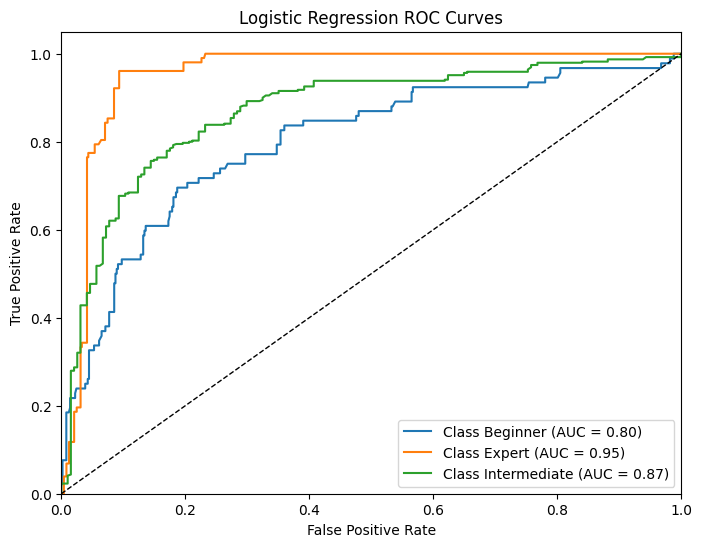


Your profile:
  Weight   : 67.0 kg
  Height   : 165.0 cm
  Age      : 21 years
  Gender   : Male
  BodyPart : Triceps

Suggested difficulty level: Intermediate

Recommended Exercises:
  1. Triceps dip (score: 1.00)
  2. Dumbbell floor press (score: 1.00)
  3. Decline EZ-bar skullcrusher (score: 1.00)

Decision paths for recommendations:

Exercise 1: Triceps dip
  Node 0: num__rating_filled (1.29) > -0.34
  Node 194: cat__bodypart_Triceps (1.00) > 0.50
  Node 774: cat__equipment_Cable (0.00) <= 0.50
  Node 775: num__rating_filled (1.29) > 0.90
  Node 815: cat__equipment_Barbell (0.00) <= 0.50
  Node 816: num__rating_filled (1.29) > 1.26
  Node 818: cat__equipment_Body Only (1.00) > 0.50
  Leaf 820 distribution: [0. 0. 1.]

Exercise 2: Dumbbell floor press
  Node 0: num__rating_filled (1.23) > -0.34
  Node 194: cat__bodypart_Triceps (1.00) > 0.50
  Node 774: cat__equipment_Cable (0.00) <= 0.50
  Node 775: num__rating_filled (1.23) > 0.90
  Node 815: cat__equipment_Barbell (0.00) <= 0.50

In [39]:
# (Re)import libraries
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    mean_squared_error
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.tree import _tree

# 1. Load & clean
df = pd.read_csv('megaGymDataset(Filtered2)(in).csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.rename(columns={
    'BodyPart': 'bodypart',
    'Equipment': 'equipment',
    'Level': 'difficulty',
    'Rating': 'rating',
    'ExerciseName': 'exercise_name'
})

# 2. Impute missing ratings via RF regressor
df_known   = df[df['rating'].notna()].copy()
df_unknown = df[df['rating'].isna()].copy()
reg_feats  = ['bodypart','equipment','difficulty']
reg_pre    = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), reg_feats)
])
Xk_enc     = reg_pre.fit_transform(df_known[reg_feats])
yk         = df_known['rating']
reg        = RandomForestRegressor(n_estimators=100, random_state=42)
Xk_tr, Xk_te, yk_tr, yk_te = train_test_split(Xk_enc, yk, test_size=0.2, random_state=42)
reg.fit(Xk_tr, yk_tr)
rmse = np.sqrt(mean_squared_error(yk_te, reg.predict(Xk_te)))
print(f"Imputer RMSE: {rmse:.3f}")
df_unknown['rating_filled'] = reg.predict(reg_pre.transform(df_unknown[reg_feats]))
df_known['rating_filled']   = df_known['rating']
df_full = pd.concat([df_known, df_unknown], ignore_index=True)

# 3. Prepare data for classification
X = df_full[['bodypart','equipment','rating_filled']]
y = df_full['difficulty']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 4. Preprocessing pipeline
numeric_features   = ['rating_filled']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',   StandardScaler())
])
categorical_features = ['bodypart','equipment']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(drop='first', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer,    numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Helper dataclass and function for evaluation
@dataclass
class ModelResult:
    name: str
    best_params: dict
    train_time: float
    pred_time: float
    accuracy: float
    report: str

def evaluate_model(search, X_train, y_train, X_test, y_test):
    t0 = time.perf_counter()
    search.fit(X_train, y_train)
    train_time = time.perf_counter() - t0
    t0 = time.perf_counter()
    y_pred = search.predict(X_test)
    pred_time = time.perf_counter() - t0
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    name = search.estimator.named_steps['clf'].__class__.__name__
    return ModelResult(name, search.best_params_, train_time, pred_time, acc, report)

# 5. Decision Tree training and evaluation
dt_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf',  DecisionTreeClassifier(class_weight='balanced', random_state=42))
])
dt_params = {
    'clf__max_depth':        [None, 5, 10, 20],
    'clf__min_samples_split':[2, 5, 10],
    'clf__criterion':        ['gini','entropy']
}
dt_search = GridSearchCV(dt_pipeline, dt_params, cv=5, n_jobs=-1)
dt_result = evaluate_model(dt_search, X_train, y_train, X_test, y_test)
print(f"\n{dt_result.name} (best params={dt_result.best_params})")
print(f"  Train time: {dt_result.train_time:.2f}s | Predict time: {dt_result.pred_time:.3f}s | Accuracy: {dt_result.accuracy:.3f}")
print(dt_result.report)

# Visualize the tree at depth=3
best_dt = dt_search.best_estimator_.named_steps['clf']
X_train_trans = dt_search.best_estimator_.named_steps['prep'].transform(X_train)
best_dt.fit(X_train_trans, y_train)
plt.figure(figsize=(12, 8))
plot_tree(
    best_dt,
    max_depth=3,
    feature_names=dt_search.best_estimator_.named_steps['prep'].get_feature_names_out(),
    class_names=best_dt.classes_,
    filled=True,
    rounded=True
)
plt.title("Decision Tree (depth=3)")
plt.show()

# 6. Logistic Regression training, evaluation, and coefficient plot
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf',  LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42))
])
lr_params = {'clf__C': [0.01, 0.1, 1, 10], 'clf__solver': ['lbfgs', 'saga']}
lr_search = GridSearchCV(lr_pipeline, lr_params, cv=5, n_jobs=-1)
lr_result = evaluate_model(lr_search, X_train, y_train, X_test, y_test)
print(f"\n{lr_result.name} (best params={lr_result.best_params})")
print(f"  Train time: {lr_result.train_time:.2f}s | Predict time: {lr_result.pred_time:.3f}s | Accuracy: {lr_result.accuracy:.3f}")
print(lr_result.report)

# 7. ROC Curves for Logistic Regression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Binarize test labels
classes = lr_search.best_estimator_.named_steps['clf'].classes_
y_test_bin = label_binarize(y_test, classes=classes)
# Get predicted probabilities
y_score = lr_search.best_estimator_.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curves")
plt.legend(loc="lower right")
plt.show()

# 8. Simulation with interpretability with interpretability
def simulate_user_recommendation():
    # 1) Collect user profile
    try:
        weight = float(input("Enter your weight (kg): "))
        height = float(input("Enter your height (cm): "))
        age    = int(input("Enter your age (years): "))
    except ValueError:
        print("Invalid numeric input. Please enter valid numbers for weight, height, and age.")
        return
    gender   = input("Enter your gender (Male/Female/Other): ")
    bodypart = input("Enter target body part (e.g., Chest, Quadriceps, Lats, Shoulders, Biceps, Hamstrings): ")
    min_rating = 4.0
    top_n      = 3

    # 2) Echo inputs
    print("\nYour profile:")
    print(f"  Weight   : {weight} kg")
    print(f"  Height   : {height} cm")
    print(f"  Age      : {age} years")
    print(f"  Gender   : {gender}")
    print(f"  BodyPart : {bodypart}")

    # 3) Map to difficulty via BMI and age
    height_m = height / 100.0
    bmi      = weight / (height_m ** 2)
    if age >= 50 or bmi >= 25 or bmi < 18.5:
        user_diff = 'Beginner'
    elif age < 30 and 18.5 <= bmi <= 23:
        user_diff = 'Expert'
    else:
        user_diff = 'Intermediate'
    print(f"\nSuggested difficulty level: {user_diff}")

    # 4) Filter candidate exercises
    candidates = df_full[
        (df_full['bodypart'].str.lower() == bodypart.lower()) &
        (df_full['rating_filled'] >= min_rating)
    ].copy()
    if candidates.empty:
        print(f"No exercises found for {bodypart} with rating >= {min_rating}.")
        return

    # 5) Score with Decision Tree pipeline
    pipeline = dt_search.best_estimator_
    probs    = pipeline.predict_proba(candidates[['bodypart','equipment','rating_filled']])
    classes  = pipeline.named_steps['clf'].classes_
    idx      = list(classes).index(user_diff)
    candidates['score'] = probs[:, idx]

    # 6) Top-N recommendations
    recs = candidates.sort_values('score', ascending=False).head(top_n)
    print("\nRecommended Exercises:")
    for rank, row in enumerate(recs.itertuples(), start=1):
        print(f"  {rank}. {row.exercise_name} (score: {row.score:.2f})")

    # 7) Interpretability: print decision paths
    feature_names = pipeline.named_steps['prep'].get_feature_names_out()
    print("\nDecision paths for recommendations:")
    for rank, row in enumerate(recs.itertuples(), start=1):
        print(f"\nExercise {rank}: {row.exercise_name}")
        sample = pd.DataFrame({
            'bodypart': [row.bodypart],
            'equipment':[row.equipment],
            'rating_filled':[row.rating_filled]
        })
        Xs       = pipeline.named_steps['prep'].transform(sample)
        node_ind = best_dt.decision_path(Xs)
        leaf_id  = best_dt.apply(Xs)[0]
        for node in node_ind.indices[node_ind.indptr[0]:node_ind.indptr[1]]:
            if best_dt.tree_.feature[node] != _tree.TREE_UNDEFINED:
                fname = feature_names[best_dt.tree_.feature[node]]
                thresh= best_dt.tree_.threshold[node]
                val   = Xs[0, best_dt.tree_.feature[node]]
                sign  = "<=" if val <= thresh else ">"
                print(f"  Node {node}: {fname} ({val:.2f}) {sign} {thresh:.2f}")
        dist = best_dt.tree_.value[leaf_id][0]
        print(f"  Leaf {leaf_id} distribution: {dist}")

# Run simulation
simulate_user_recommendation()
